# Image Bijective Graph


In [1]:
from pyMeasure.Code.DataHandlers.GraphModels import *
import PIL
import os
import re
import base64
from scipy import misc

Importing Code.Utils.Names
Importing Code.DataHandlers.NISTModels
Importing Code.DataHandlers.GeneralModels
Importing Code.DataHandlers.TouchstoneModels
Importing Code.DataHandlers.XMLModels
Importing Code.DataHandlers.RadiCALModels
Importing Code.DataHandlers.ZipModels
Importing Code.DataHandlers.Translations
Importing Code.DataHandlers.StatistiCALModels
Importing Code.DataHandlers.MUFModels
Importing Code.Analysis.SParameter
Importing Code.InstrumentControl.Instruments
Importing Code.InstrumentControl.Experiments


In [156]:
def remove_circular_paths(path):
    """Removes pieces of the path that just end on the same node"""
    edge_pattern=re.compile("edge_(?P<begin_node>\w+)_(?P<end_node>\w+)_(?P<iterator>\w+)")
    past_locations=[]
    
    for index,edge in enumerate(path):
        match=re.match(edge_pattern,edge)
        begin_node=match.groupdict()["begin_node"]
        end_node=match.groupdict()["end_node"]
        past_locations.append(begin_node)
        #print("{0} is {1}".format("past_locations",past_locations))
    new_path=[]
    node_index=0
    between_list=[False for item in past_locations]
    while(node_index<len(past_locations)):
        node=past_locations[node_index]
        old_path=new_path
        new_path=[]
        # if you visit a location more than one
        number_of_visits=past_locations.count(node)
        if number_of_visits>1:
            #print("{0} is {1}".format("node",node))
            #print("{0} is {1}".format("past_locations",past_locations))
            # Now find all the visits to that location
            equality_list=map(lambda x:x==node,past_locations)
            print("{0} is {1}".format("equality_list",equality_list))
            # You are intially not between visits
            between=False
            
            # every time you cross that node you flip between, as long as there are 
            visit_number=0
            for index,equality in enumerate(equality_list):
                if equality:
                    # add one to the visit number
                    visit_number+=1
                    # Flip the between truth value if it is the first or last 
                    # visits only
                    if visit_number==1 or visit_number==number_of_visits:
                        between=not between
                        between_list[index]=between or between_list[index]
                    else:
                        between_list[index]=between or between_list[index]
                        
                else:
                    between_list[index]=between or between_list[index] 
        print("{0} is {1}".format("between_list",between_list))
        for index,item in enumerate(between_list):
            if not item:
                new_path.append(path[index])
        node_index+=1

    if new_path in [[]]:
        new_path=path
                    
    return new_path

def edge_1_to_2(in_string):
    return in_string.splitlines()
    
def edge_2_to_1(string_list):
    return string_list_collapse(string_list)

class Graph():
    def __init__(self,**options):
        """Initializes the graph. The first 2 nodes and two edges forming a bijection between them are required"""
        defaults={"graph_name":"Graph",
                  "node_names":['n1','n2'],
                  "node_descriptions":["A plain string",
                                       "A list of strings with no \\n, created with string.splitlines()"],
                  "current_node":'n1',
                  "state":[1,0],
                  "data":"This is a test string\n it has to have multiple lines \n and many characters 34%6\n^",
                  "edge_2_to_1":edge_2_to_1,
                  "edge_1_to_2":edge_1_to_2
                 }
        self.options={}
        for key,value in defaults.iteritems():
            self.options[key]=value
        for key,value in options.iteritems():
            self.options[key]=value
        self.elements=['graph_name','node_names','node_descriptions','current_node','state','data']
        for element in self.elements:
            self.__dict__[element]=self.options[element]
        self.edges=[]
        self.edge_matrices=[]
        self.state_matrix=np.matrix(self.state).T
        # Add the first 2 edges, required to intialize the graph properly
        self.add_edge(self.node_names[0],self.node_names[1],self.options["edge_1_to_2"])
        self.add_edge(self.node_names[1],self.node_names[0],self.options["edge_2_to_1"])
        self.jumps=[]
        self.external_node_names=[]
        self.external_node_descriptions=[]

    def get_description_dictionary(self):
        dictionary={node_name:self.node_descriptions[index] for index,node_name in enumerate(self.node_names)}
        return dictionary
    
    def set_state(self,node_name,node_data):
        """Sets the graph state to be the state specified by node_name, and node_data"""
        try:
            current_node_state_position=self.node_names.index(node_name)
            self.current_node=node_name
            self.data=node_data
            self.state=[0 for i in range(len(self.node_names))]
            self.state[current_node_state_position]=1
            self.state_matrix=np.matrix(self.state).T
        except:
            print("Could not set the state of graph: {0}".format(self.graph_name))
            raise
            
    def add_edge(self,begin_node=None,end_node=None,edge_function=None):
        """Adds an edge mapping one node to another, required input is begin_node (it's name)
        end_node, and the edge function"""
        # check to see if edge is defined if it is increment a number
        edge_match=re.compile("edge_{0}_{1}".format(begin_node,end_node))
        keys=self.__dict__.keys()
        #print keys
        iterator=0
        for key in keys:
            if re.match(edge_match,key):
                iterator+=1
        edge_name="edge_{0}_{1}_{2:0>3d}".format(begin_node,end_node,iterator)
        self.__dict__[edge_name]=edge_function
        self.edges.append(edge_name)
        edge_matrix=np.zeros((len(self.state),len(self.state)))
        begin_position=self.node_names.index(begin_node)
        end_position=self.node_names.index(end_node)
        edge_matrix[end_position][begin_position]=1
        edge_matrix=np.matrix(edge_matrix)
        self.edge_matrices.append(edge_matrix)
        
    def add_jump(self,begin_node=None,end_node=None,jump_function=None):
        """Adds a jump mapping one internal node to an external node, required input is begin_node (it's name)
        end_node, and the edge function"""
        # check to see if edge is defined if it is increment a number
        jump_match=re.compile("jump_{0}_{1}".format(begin_node,end_node))
        keys=self.__dict__.keys()
        #print keys
        iterator=0
        for key in keys:
            if re.match(jump_match,key):
                iterator+=1
        jump_name="jump_{0}_{1}_{2:0>3d}".format(begin_node,end_node,iterator)
        self.__dict__[jump_name]=jump_function
        self.jumps.append(jump_name)

        
    def move_to(self,path):
        """Changes the state of the graph by moving along the path specified"""
        print path
        for index,edge in enumerate(path):
            #print edge
            edge_pattern='edge_(?P<begin_node>\w+)_(?P<end_node>\w+)_(?P<iterator>\w+)'
            match=re.match(edge_pattern,edge)
            begin_node=match.groupdict()['begin_node']
            end_node=match.groupdict()['end_node']
            print("moving {0} -> {1}".format(begin_node,end_node))
            #print self.data
            self.data=self.__dict__[edge](self.data)
            #print self.data
            self.current_node=match.groupdict()['end_node']
            self.state=[0 for i in range(len(self.node_names))]
            position=self.node_names.index(self.current_node)
            self.state[position]=1
            self.state_matrix=np.matrix(self.state).T
            #print self.state
            #print self.current_node
            
    def virtual_move_to(self,path):
        """virtual_move_to simulates moving but does not change the state of the graph"""
        #print path
        temp_state=self.state
        temp_data=self.data
        temp_current_node=self.current_node
        temp_node_names=self.node_names
        for index,edge in enumerate(path):
            #print edge
            edge_pattern='edge_(?P<begin_node>\w+)_(?P<end_node>\w+)_(?P<iterator>\w+)'
            match=re.match(edge_pattern,edge)
            begin_node=match.groupdict()['begin_node']
            end_node=match.groupdict()['end_node']
            #print("moving {0} -> {1}".format(begin_node,end_node))
            #print self.data
            temp_data=self.__dict__[edge](temp_data)
            #print self.data
            temp_current_node=match.groupdict()['end_node']
            temp_state=[0 for i in range(len(temp_node_names))]
            position=temp_node_names.index(temp_current_node)
            temp_state[position]=1
            #print temp_state
            #print self.state
            #print self.current_node  
            
    def __str__(self):
        return str(self.data)
    
    def add_node(self,node_name,edge_into_node_begin,edge_into_node_function,edge_out_node_end,
                 edge_out_node_function):
        """Adds a node to the graph. Required input is node_name (a string with no spaces), 
        a reference to an entering node,the function mapping the entering node to the new node, 
        a reference to an exiting node and the function mapping the
        new node to the exiting node."""
        # first check if node into and out of node is good
        self.node_names.append(node_name)
        self.state.append(0)
        self.state_matrix=np.matrix(self.state).T
        for index,matrix in enumerate(self.edge_matrices):
            pad_row=np.zeros((1,len(matrix)))
            new_matrix=np.concatenate((matrix, pad_row), axis=0)
            pad_column=np.zeros((1,len(self.node_names)))
            new_matrix=np.concatenate((new_matrix, pad_column.T), axis=1)
            #print("New matrix is :\n{0}".format(new_matrix))
            self.edge_matrices[index]=new_matrix
        self.add_edge(begin_node=node_name,end_node=edge_out_node_end,edge_function=edge_out_node_function)
        self.add_edge(begin_node=edge_into_node_begin,end_node=node_name,edge_function=edge_into_node_function)
        
    def add_external_node(self,external_node_name,jump_into_node_begin,jump_into_node_function):
        """Adds an external node to the graph. Required input is node_name (a string with no spaces), 
        a reference to an entering node,the function mapping the entering node to the new external node"""
        # first check if node into and out of node is good
        self.external_node_names.append(external_node_name)
        self.add_jump(begin_node=jump_into_node_begin,end_node=external_node_name,jump_function=jump_into_node_function)
    
    def jump_to_external_node(self,external_node_name):
        """Returns the result of the jump, the graph is left in the node that is the begining of the jump"""
        end_node=external_node_name
        jump_pattern='jump_(?P<begin_node>\w+)_{0}_(?P<iterator>\w+)'.format(end_node)
        for jump in self.jumps[:]:
            jump_match=re.match(jump_pattern,jump,re.IGNORECASE)
            if jump_match:
                jump_to_use=jump
                begin_node=jump_match.groupdict()["begin_node"]
                
        self.move_to_node(begin_node)
        return self.__dict__[jump_to_use](self.data)
        

    
    def path_length(self,path,num_repeats=10):
        """Determines the length of a given path, currently the metric is based on the time to move to."""
        begin_time=datetime.datetime.now()
        #num_repeats=100
        for i in range(num_repeats):
            self.virtual_move_to(path)
        end_time=datetime.datetime.now()
        delta_t=end_time-begin_time
        path_length=delta_t.total_seconds()/float(num_repeats)
        if path_length ==0.0:
            print("Warning the path length is less than 1 microsecond," 
                  "make sure num_repeats is high enough to measure it.")
        return path_length
                
    def is_path_valid(self,path):
        """Returns True if the path is valid from the current node position or False otherwise"""
        null_state=[0 for i in range(len(self.node_names))]
        null_state_matrix=np.matrix(null_state).T
        new_state=np.matrix(self.state).T
        for index,edge in enumerate(path):
            #print index
            #print edge
            edge_position=self.edges.index(edge)
            move_matrix=self.edge_matrices[edge_position]
            #print move_matrix
            new_state=move_matrix*new_state
            if new_state.any()==null_state_matrix.any():
                #print new_state
                #print null_state_matrix
                return False
        return True
            
            
    def get_entering_nodes(self,node): 
        """Returns all nodes that have an edge that enter the specificed node"""
        enter_edge_pattern=re.compile('edge_(?P<begin_node>\w+)_{0}_(?P<iterator>\w+)'.format(node))
        enter_nodes=[]
        for index,edge in enumerate(self.edges):
            enter_match=re.match(enter_edge_pattern,edge)
            if enter_match:
                enter_node=enter_match.groupdict()['begin_node']
                enter_nodes.append(enter_node)
        return enter_nodes
    
    def get_entering_edges(self,node): 
        """Returns all edges that enter the specificed node"""
        enter_edge_pattern=re.compile('edge_(?P<begin_node>\w+)_{0}_(?P<iterator>\w+)'.format(node))
        enter_edges=[]
        for index,edge in enumerate(self.edges):
            if re.match(enter_edge_pattern,edge):
                enter_edges.append(edge)
        return enter_edges
    
    def get_exiting_edges(self,node):
        """Returns all edges that exit the specificed node"""
        exit_edge_pattern=re.compile('edge_{0}_(?P<end_node>\w+)_(?P<iterator>\w+)'.format(node))
        exit_edges=[]
        for index,edge in enumerate(self.edges):
            if re.match(exit_edge_pattern,edge):
                exit_edges.append(edge)
        return exit_edges 
    
    def get_exiting_nodes(self,node): 
        """Returns all nodes that have an edge leaving the specificed node"""
        exit_edge_pattern=re.compile('edge_{0}_(?P<end_node>\w+)_(?P<iterator>\w+)'.format(node))
        exit_nodes=[]
        for index,edge in enumerate(self.edges):
            exit_match=re.match(exit_edge_pattern,edge)
            if exit_match:
                exit_node=exit_match.groupdict()['end_node']
                exit_nodes.append(exit_node)
        return exit_nodes
    
    def get_path(self,first_node,last_node):
        """Returns the first path found between first node and last node, three step paths are broken"""
        #TODO: Remove Circular Paths
        edge_pattern=re.compile('edge_(?P<begin_node>\w+)_(?P<end_node>\w+)_(?P<iterator>\w+)')
        exit_paths=self.get_exiting_edges(first_node)
        next_nodes=self.get_exiting_nodes(first_node)
        #be careful here using the wrong assignment statement breaks this function 
        possible_paths=[]
        for exit_path in exit_paths:
            possible_paths.append([exit_path])
        #print("{0} is {1}".format('possible_paths',possible_paths))
        for i in range(len(self.node_names)**2):
            #print("{0} is {1}".format('i',i))
            #print("{0} is {1}".format('possible_paths',possible_paths))
            for index,path in enumerate(possible_paths):
                #print("{0} is {1}".format('index',index))
                last_edge=path[-1]
                #print("{0} is {1}".format('last_edge',last_edge))
                match=re.match(edge_pattern,last_edge)
                begin_node=match.groupdict()['begin_node']
                end_node=match.groupdict()['end_node']
                #print("{0} is {1}".format('end_node',end_node))
                if end_node==last_node:
                    #print("The path found is {0}".format(path))
                    return remove_circular_paths(path)
                next_possible_paths=[]
                next_edges=self.get_exiting_edges(end_node)
                next_nodes=self.get_exiting_nodes(end_node)
                #print("{0} is {1}".format('next_edges',next_edges))
                for next_edge_index,next_edge in enumerate(next_edges):
                    #print("{0} is {1}".format('next_edge_index',next_edge_index))
                    #be careful here using the wrong assignment statement breaks this function 
                    #next_path=path is a deal breaker!! 
                    next_path=[]
                    for edge in path:
                        next_path.append(edge)
                    #print("{0} is {1}".format('next_path',next_path))
                    #print("{0} is {1}".format('next_edge',next_edge))
                    #next_node=next_nodes[index]
                    #print next_node
                    next_match=re.match(edge_pattern,next_edge)
                    next_node=next_match.groupdict()["end_node"]
                    begin_node_next_edge=next_match.groupdict()["begin_node"]
                    #print("{0} is {1}".format('next_node',next_node))
                    #print("{0} is {1}".format('begin_node_next_edge',begin_node_next_edge))
                    if next_node==last_node and begin_node_next_edge==end_node:
                        next_path.append(next_edge)
                        print("The path found is {0}".format(next_path))
                        return remove_circular_paths(next_path)
                    elif begin_node_next_edge==end_node:
                        next_path.append(next_edge)
                        # This keeps it from getting stuck on circular paths
                        if next_edge in path:
                        #ossible_paths=possible_paths
                            #print("next_edge was already in path")
                            continue
                        next_possible_paths.append(next_path)
                        
                        #print("{0} is {1}".format('next_possible_paths',next_possible_paths))
                    else:
                        print("Path is not found")
                        pass

                    #print("{0} is {1}".format('next_possible_paths',next_possible_paths))
                if next_possible_paths:
                    possible_paths=next_possible_paths
                #print("{0} is {1}".format('possible_paths',possible_paths))
    
    def move_to_node(self,node):
        """Moves from current_node to the specified node"""
        path=self.get_path(self.current_node,node)
        self.move_to(path)
            
    def check_closed_path(self):
        """Checks that data is not changed for the first closed path found. Returns True if data==data after
        moving around the closed path, False otherwise. Starting point is current_node """
        temp_data=self.data
        path=self.get_path(self.current_node,self.current_node)
        if self.is_path_valid(path):
            pass
        else:
            print("Path is not valid, graph definition is broken")
            raise
        out=temp_data==self.data
        out_list=[self.current_node,path,out]
        print("The assertion that the data remains unchanged,\n" 
              "for node {0} following path {1} is {2}".format(*out_list))
        return out 
    
    def is_graph_isomorphic(self):
        """Returns True if all nodes have closed paths that preserve the data, False otherwise"""
        out=True
        for node in self.node_names:
            self.move_to_node(node)
            if not self.check_closed_path:
                out=False
        return out
    
    def show(self,**options):
        """Shows the graph using matplotlib and networkx"""
        # Should be seperated to allow for fixed presentation?
        defaults={"descriptions":False,"edge_descriptions":False,"save_plot":False,
                 "path":None,"active_node":True,"directory":None,"specific_descriptor":self.graph_name.replace(" ","_"),
                  "general_descriptor":"plot","file_name":None,
                 "arrows":True,"node_size":1000,"font_size":10}
        show_options={}
        for key,value in defaults.iteritems():
            show_options[key]=value
        for key,value in options.iteritems():
            show_options[key]=value
        if show_options["directory"] is None:
            show_options["directory"]=os.getcwd() 
        new_graph=networkx.DiGraph()
        edge_pattern=re.compile("edge_(?P<begin_node>\w+)_(?P<end_node>\w+)_(?P<iterator>\w+)")
        jump_pattern=re.compile("jump_(?P<begin_node>\w+)_(?P<end_node>\w+)_(?P<iterator>\w+)")
        for node in self.node_names:
            new_graph.add_node(node)
        for node in self.external_node_names:
            new_graph.add_node(node)
        for edge in self.edges:
            match=re.match(edge_pattern,edge)
            if match:
                begin_node=match.groupdict()["begin_node"]
                end_node=match.groupdict()["end_node"]
                new_graph.add_edge(begin_node,end_node)
                #print("Begin Node = {0}, End Node= {1}".format(begin_node,end_node))
        #print("{0} is {1}".format('new_graph.nodes()',new_graph.nodes()))
        for jump in self.jumps:
            match=re.match(jump_pattern,jump)
            if match:
                begin_node=match.groupdict()["begin_node"]
                end_node=match.groupdict()["end_node"]
                new_graph.add_edge(begin_node,end_node)
                
        if show_options["active_node"]:
            node_colors=[]
            for node in new_graph.nodes():
                if node==self.current_node:
                    node_colors.append('b')
                else:
                    if node in self.node_names:
                        node_colors.append('r')
                    elif node in self.external_node_names:
                        node_colors.append('g')
        else:
            node_colors=['r' for node in self.node_names]+['g' for node in self.node_names]
        #print("{0} is {1}".format('node_colors',node_colors))
        if show_options["descriptions"]:
            node_labels={node:self.node_descriptions[index] for index, 
                               node in enumerate(self.node_names)}
            if self.external_node_names:
                for index,node in enumerate(self.external_node_names):
                    node_labels[node]=self.external_node_descriptions[index]
            networkx.draw_networkx(new_graph,arrows=show_options["arrows"],
                       labels=node_labels,node_color=node_colors,
                                   node_size=show_options["node_size"],font_size=show_options["font_size"])
            #print("{0} is {1}".format('node_labels',node_labels))
        else:
            networkx.draw_networkx(new_graph,arrows=show_options["arrows"],node_color=node_colors,
                                  node_size=show_options["node_size"],font_size=show_options["font_size"])
            
        plt.suptitle(self.options["graph_name"])
        if show_options["file_name"] is None:
            file_name=auto_name(specific_descriptor=show_options["specific_descriptor"],
                                general_descriptor=show_options["general_descriptor"],
                                directory=show_options["directory"],extension='png',padding=3)
        else:
            file_name=show_options["file_name"]
        if show_options["save_plot"]:
            #print file_name
            if show_options["path"]:
                plt.savefig(show_options["path"])
            else:
                plt.savefig(os.path.join(show_options["directory"],file_name))
        else:
            plt.show()
            


In [4]:
im=PIL.Image.open('Rectangular_Graph_plot_20161130_001.png')

In [157]:
file_name='Rectangular_Graph_plot_20161130_001.png'
directory=os.getcwd()
def png_to_jpg(png_file_name):
    [root_name,extension]=png_file_name.split(".")
    jpeg_file_name=root_name+".jpg"
    PIL.Image.open(png_file_name).save(jpeg_file_name)
    return jpeg_file_name
def file_to_Image(file_path):
    new_image=PIL.Image.open(file_path)
    if re.search(".gif",file_path,re.IGNORECASE):
        new_image=new_image.convert("RGB")
    return new_image

def Image_to_file(pil_image,file_path=None):
    if file_path is None:
        file_path=pil_image.filename
    pil_image.save(file_path)
    return file_path

def Image_to_file_type(pil_image,file_path=None,extension="png"):
    
    if file_path is None:
        file_path=pil_image.filename
    root_name=file_path.split(".")[0]
    new_file_name=root_name+"."+extension.replace(".","")
    if re.search('jp|bmp',extension,re.IGNORECASE):
        pil_image.convert('RGB')
    print("{0} is {1}".format("pil_image.mode",pil_image.mode))
    pil_image.save(new_file_name)
    return new_file_name
    
def Image_to_thumbnail(pil_image,file_path="thumbnail.jpg"):
    size = (64, 64)
    temp_image=pil_image.copy()
    temp_image.thumbnail(size)
    temp_image.save(file_path)
    return file_path

def png_to_base64(file_name):
    in_file=open(file_name, "rb")
    encoded=base64.b64encode(in_file.read())
    return encoded

def base64_to_png(base64_encoded_png,file_name="test.png"):
    out_file=open(file_name, "wb")
    decoded=base64.b64decode(base64_encoded_png)
    out_file.write(decoded)
    out_file.close()
    return file_name
 
    
def png_to_ndarray(file_name):
    nd_array=misc.imread(file_name)
    return nd_array

def ndarray_to_png(nd_array,file_name="test.png"):
    misc.imsave(file_name,nd_array)
    return file_name

# change this to base64png
def base64png_to_embeded_html(base64_encoded_png):
    html_string="<img src='data:image/png;base64,{0}' />".format(base64_encoded_png)
    return html_string

def embeded_html_to_base64png(html_string):
    pattern=re.compile("<img src='data:image/png;base64,(?P<data>.+)' />")
    match=re.search(pattern,html_string)
    if match:
        encoded=match.groupdict()["data"]
    else:
        raise
    return encoded



In [4]:
"Image".split(".")

['Image']

In [5]:
png_to_jpg(os.path.join(directory,file_name))

'C:\\Users\\sandersa\\PyCharm Projects\\Jupyter-Notebooks\\Rectangular_Graph_plot_20161130_001.jpg'

In [6]:
im.filename

'Rectangular_Graph_plot_20161130_001.png'

In [158]:
graph_options={"graph_name":"Image Graph",
                  "node_names":['Image','png'],
                  "node_descriptions":["PIL Image","png"],
                  "current_node":'Image',
                  "state":[1,0],
                  "data":im,
                  "edge_2_to_1":file_to_Image,
                  "edge_1_to_2":lambda x: Image_to_file_type(x,file_path="test",extension="png")
                 }
image_graph=Graph(**graph_options)

In [17]:
image_graph.show()

In [159]:
image_graph.add_node("jpg","Image",lambda x: Image_to_file_type(x,file_path="test",extension="jpg"),
                     "Image",file_to_Image)
image_graph.add_node("tiff","Image",lambda x: Image_to_file_type(x,file_path="test",extension="tiff"),
                     "Image",file_to_Image)
image_graph.add_node("gif","Image",lambda x: Image_to_file_type(x,file_path="test",extension="gif"),
                     "Image",file_to_Image)
image_graph.add_node("bmp","Image",lambda x: Image_to_file_type(x,file_path="test",extension="bmp"),
                     "Image",file_to_Image)
image_graph.add_node("base64","png",png_to_base64,
                     "png",base64_to_png)
image_graph.add_node("embededHTML","base64",base64png_to_embeded_html,
                     "base64",embeded_html_to_base64png)
image_graph.add_node("ndarray","png",png_to_ndarray,
                     "png",ndarray_to_png)
image_graph.add_external_node("thumbnail","Image",Image_to_thumbnail)

In [91]:
image_graph.show()

In [11]:
print image_graph.edges

['edge_Image_png_000', 'edge_png_Image_000', 'edge_jpg_Image_000', 'edge_Image_jpg_000', 'edge_tiff_Image_000', 'edge_Image_tiff_000', 'edge_gif_Image_000', 'edge_Image_gif_000', 'edge_bmp_Image_000', 'edge_Image_bmp_000', 'edge_base64_png_000', 'edge_png_base64_000', 'edge_embededHTML_base64_000', 'edge_base64_embededHTML_000', 'edge_ndarray_png_000', 'edge_png_ndarray_000']


The path found is ['edge_Image_bmp_000', 'edge_bmp_Image_000', 'edge_Image_gif_000', 'edge_gif_Image_000', 'edge_Image_tiff_000', 'edge_tiff_Image_000', 'edge_Image_jpg_000', 'edge_jpg_Image_000', 'edge_Image_png_000', 'edge_png_base64_000', 'edge_base64_embededHTML_000']
equality_list is [True, False, True, False, True, False, True, False, True, False, False]
between_list is [True, True, True, True, True, True, True, True, False, False, False]
between_list is [True, True, True, True, True, True, True, True, False, False, False]
equality_list is [True, False, True, False, True, False, True, False, True, False, False]
between_list is [True, True, True, True, True, True, True, True, False, False, False]
between_list is [True, True, True, True, True, True, True, True, False, False, False]
equality_list is [True, False, True, False, True, False, True, False, True, False, False]
between_list is [True, True, True, True, True, True, True, True, False, False, False]
between_list is [True, True


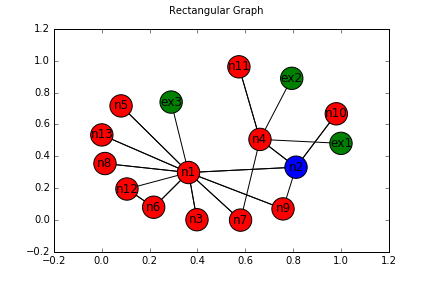

In [160]:
from ipywidgets import *
from IPython.display import Image,display,HTML
def move_and_show(node_name):
    image_graph.move_to_node(node_name)
    print("{0}".format(node_name))
    if node_name is "Image":
        print("PIL Image Class")
    elif node_name in ["png","jpg"]:
        display(Image(image_graph.data,embed=True))
    elif node_name in ["base64"]:
        display(HTML("<img src='data:image/png;base64,{0}' />".format(image_graph.data)))
    elif node_name in ["embededHTML"]:
        display(HTML(image_graph.data))
        #print image_graph.data 
    elif node_name in ["ndarray"]:
        plt.imshow(image_graph.data)
        plt.show()
    else:
        display(HTML("<img src='{0}' />".format(image_graph.data)))
interact(move_and_show,node_name=image_graph.node_names)

In [152]:
def remove_circular_paths(path):
    """Removes pieces of the path that just end on the same node"""
    edge_pattern=re.compile("edge_(?P<begin_node>\w+)_(?P<end_node>\w+)_(?P<iterator>\w+)")
    past_locations=[]
    
    for index,edge in enumerate(path):
        match=re.match(edge_pattern,edge)
        begin_node=match.groupdict()["begin_node"]
        end_node=match.groupdict()["end_node"]
        past_locations.append(begin_node)
        #print("{0} is {1}".format("past_locations",past_locations))
    new_path=[]
    node_index=0
    between_list=[False for item in past_locations]
    while(node_index<len(past_locations)):
        node=past_locations[node_index]
        old_path=new_path
        new_path=[]
        # if you visit a location more than one
        number_of_visits=past_locations.count(node)
        if number_of_visits>1:
            #print("{0} is {1}".format("node",node))
            #print("{0} is {1}".format("past_locations",past_locations))
            # Now find all the visits to that location
            equality_list=map(lambda x:x==node,past_locations)
            print("{0} is {1}".format("equality_list",equality_list))
            # You are intially not between visits
            between=False
            
            # every time you cross that node you flip between, as long as there are 
            visit_number=0
            for index,equality in enumerate(equality_list):
                if equality:
                    # add one to the visit number
                    visit_number+=1
                    # Flip the between truth value if it is the first or last 
                    # visits only
                    if visit_number==1 or visit_number==number_of_visits:
                        between=not between
                        between_list[index]=between or between_list[index]
                    else:
                        between_list[index]=between or between_list[index]
                        
                else:
                    between_list[index]=between or between_list[index] 
        print("{0} is {1}".format("between_list",between_list))
        for index,item in enumerate(between_list):
            if not item:
                new_path.append(path[index])
        node_index+=1

    if new_path in [[]]:
        new_path=path
                    
    return new_path


In [153]:
path1=['edge_Image_bmp_000', 'edge_bmp_Image_000', 
      'edge_Image_gif_000', 'edge_gif_Image_000', 
      'edge_Image_tiff_000','edge_tiff_Image_000', 
      'edge_Image_jpg_000', 'edge_jpg_Image_000', 
      'edge_Image_png_000', 'edge_png_base64_000', 'edge_base64_embededHTML_000']
path2=['edge_Image_bmp_000', 'edge_bmp_Image_000', 
      'edge_Image_gif_000', 'edge_gif_Image_000', 
      'edge_Image_tiff_000','edge_tiff_Image_000', 
      'edge_Image_png_000', 'edge_png_base64_000', 'edge_base64_embededHTML_000']
path3=['edge_Image_bmp_000', 'edge_bmp_Image_000', 
      'edge_Image_gif_000', 'edge_gif_Image_000', 
      'edge_Image_png_000', 'edge_png_base64_000', 'edge_base64_embededHTML_000']
path4=['edge_Image_bmp_000', 'edge_bmp_Image_000', 
      'edge_Image_png_000', 'edge_png_base64_000', 'edge_base64_embededHTML_000']
path5=['edge_Image_png_000','edge_Image_bmp_000', 'edge_bmp_fake_000','edge_fake_fake2_000',
      'edge_fake2_Image_000', 
       'edge_png_base64_000', 'edge_base64_embededHTML_000']
path6=['edge_jpg_Image_000', 
      'edge_Image_bmp_000', 'edge_bmp_Image_000', 
      'edge_Image_gif_000', 'edge_gif_Image_000', 
      'edge_Image_tiff_000','edge_tiff_Image_000', 
      'edge_Image_png_000', 'edge_png_base64_000', 'edge_base64_embededHTML_000']

In [155]:
print remove_circular_paths(path1)

equality_list is [True, False, True, False, True, False, True, False, True, False, False]
between_list is [True, True, True, True, True, True, True, True, False, False, False]
between_list is [True, True, True, True, True, True, True, True, False, False, False]
equality_list is [True, False, True, False, True, False, True, False, True, False, False]
between_list is [True, True, True, True, True, True, True, True, False, False, False]
between_list is [True, True, True, True, True, True, True, True, False, False, False]
equality_list is [True, False, True, False, True, False, True, False, True, False, False]
between_list is [True, True, True, True, True, True, True, True, False, False, False]
between_list is [True, True, True, True, True, True, True, True, False, False, False]
equality_list is [True, False, True, False, True, False, True, False, True, False, False]
between_list is [True, True, True, True, True, True, True, True, False, False, False]
between_list is [True, True, True, Tru

In [14]:
image_graph.jump_to_external_node("thumbnail")

['edge_Image_png_000', 'edge_png_Image_000']
moving Image -> png
pil_image.mode is RGBA
moving png -> Image


'thumbnail.jpg'

In [15]:
image_graph.show()

In [16]:
from scipy.io import savemat,loadmat
new_figure=loadmat("PropagationConstant.fig")

In [17]:
def fig_to_matplotlib(filename,fignr=1):
    "Function that uses loadmat to create a matplotlib plot of a matlab fig file"
    from scipy.io import loadmat
    from numpy import size
    from matplotlib.pyplot import plot,figure,hold,xlabel,ylabel,show,clf,xlim,legend
    d = loadmat(filename,squeeze_me=True, struct_as_record=False)
    ax1 = d['hgS_070000'].children
    if size(ax1) > 1:
        legs= ax1[1]
        ax1 = ax1[0]
    else:
        legs=0
    figure(fignr)
    clf()
    hold(True)
    counter = 0    
    for line in ax1.children:
        if line.type == 'graph2d.lineseries':
            if hasattr(line.properties,'Marker'):
                mark = "%s" % line.properties.Marker
                mark = mark[0]
            else:
                mark = '.'
            if hasattr(line.properties,'LineStyle'):
                linestyle = "%s" % line.properties.LineStyle
            else:
                linestyle = '-'
            if hasattr(line.properties,'Color'):
                r,g,b =  line.properties.Color
            else:
                r = 0
                g = 0
                b = 1
            if hasattr(line.properties,'MarkerSize'):
                marker_size = line.properties.MarkerSize
            else:
                marker_size = 1                
            x = line.properties.XData
            y = line.properties.YData
            plot(x,y,marker=mark,linestyle=linestyle,color=(r,g,b),markersize=marker_size)
        elif line.type == 'text':
            if counter <1:
                #print(dir(line.properties))
                counter += 1
            elif counter < 2:
                #print dir(line.properties.String)
                xlabel("%s" % line.properties.String,fontsize = 16)
                counter += 1 
            elif counter < 3:
                #print dir(line.properties.String)
                ylabel("%s" % line.properties.String,fontsize = 16)
                counter += 1 
    xlim(ax1.properties.XLim)
    if legs:        
        leg_entries = tuple(legs.properties.String)
        py_locs = ['upper center','lower center','right','left','upper right','upper left','lower right','lower left','best']
        MAT_locs=['North','South','East','West','NorthEast', 'NorthWest', 'SouthEast', 'SouthWest','Best']
        Mat2py = dict(zip(MAT_locs,py_locs))
        location = legs.properties.Location
        legend(leg_entries,loc=Mat2py[location])
    hold(False)
    show()

In [18]:
fig_to_matplotlib("PropagationConstant.fig")

In [19]:
fig_to_matplotlib("CharacteristicImpedance.fig")

<img src="test.png" />


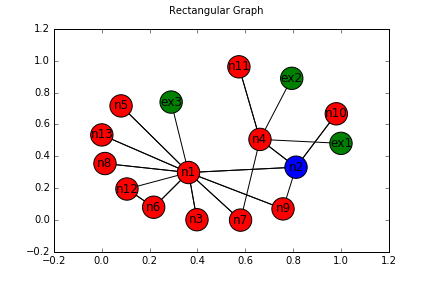

In [20]:
import base64
in_file=open("test.png", "rb")
encoded = base64.b64encode(in_file.read())
in_file.close()
display(HTML("<img src='data:image/png;base64,{0}' />".format(encoded)))

In [21]:
base64_to_png(encoded)

'test.png'

In [22]:
decoded= base64.b64decode(base64.b64encode(open("test.png", "rb").read()))

In [23]:
decoded==open("test.png", "rb").read()

True

In [24]:
out_file=open("test2.png","wb")

In [25]:
out_file.write(open("test.png", "rb").read())

In [26]:
out_file.close()

In [27]:
 from scipy import misc

In [28]:
image_array=misc.imread("test.png")

In [29]:
plt.show()

In [30]:
def embeded_html_to_base64png(html_string):
    pattern=re.compile("<img src='data:image/png;base64,(?P<data>.+)' />")
    match=re.search(pattern,html_string)
    if match:
        encoded=match.groupdict()["data"]
    else:
        raise
    return encoded
html_string="<img src='data:image/png;base64,{0}' />".format(encoded)
embeded_html_to_base64png(html_string)

'iVBORw0KGgoAAAANSUhEUgAAAbAAAAEgCAYAAADVKCZpAABxiElEQVR4nO3dd3xT1fvA8U/SmaS0ZVNaRikto5S2UPZeIrJUhqCCAoKKAgoOUBQQFRBRlgqKggtB/CpLQFkFypBN2XuWvbp3nt8fKf1RaOlKmgTO+/XKiyY599znNvQ8ueeee45GRARFURRFsTNaawegKIqiKAWhEpiiKIpil1QCUxRFUeySSmCKoiiKXVIJTFEURbFLKoEpdsHBwYE6deoQFBRE165diYmJKVA9S5Ys4ciRI2aO7sF+/PFHhgwZUqg6Tpw4QefOnfH396devXq0adOGiIgIM0UIxYoVM1tdilJUVAJT7ILBYGD37t3s37+f4sWL89VXXxWonsWLF3Pw4EEzR5c7jUaT57Lp6elZnicnJ9OxY0deeeUVjh8/zo4dO5gxYwanTp3KdVtLxKcotkIlMMXuNGrUiKioqMznn3/+OfXr1yckJIRx48Zlvv7TTz8RHBxMaGgoL7zwAlu3bmXp0qW888471KlTh9OnTzNnzhzq169PaGgoPXr0ICkpCYB+/foxbNgwmjRpQtWqVfnzzz8BEBEGDx5MzZo1ad++PR07dsx8z9fXl5s3bwKwa9cuWrVqdV/sy5cvp2HDhtStW5fHHnuMa9euATBu3Dj69u1L06ZN6du3b5Ztfv31Vxo3bkzHjh0zX6tZs2ZmuXu3PXv2LM2bNycsLIywsDC2bdsGwIYNG2jRogWdOnWievXqDB48OLM+EWH06NGEhITQuHHjzLgUxZapBKbYhTv326enp7N27Vq6dOkCwOrVqzl+/Djbt29nz5497Ny5k4iICA4dOsSnn35KeHg4e/bsYdq0aTRq1IguXbowefJkdu/eja+vL926dcvctnr16nz//feZ+7x8+TKbN29m2bJlvPvuuwD873//49y5cxw6dIiffvqJrVu3Zpa/9ywmu7OaZs2asW3bNnbt2sUzzzzDZ599lvn